#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [87]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

## Анализ

In [88]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [90]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [91]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [92]:
data.shape

(26496, 1)

In [93]:
print(f'Количество пропусков: {data.isna().sum()}')

Количество пропусков: num_orders    0
dtype: int64


In [94]:
data.sort_index(inplace=True)

*Ресемплирование*

Ресемплирование данных делаем по одному часу. Так как нужно спрогнозировать количество заказов такси на следующий час.

In [95]:
data = data.resample('1H').sum()

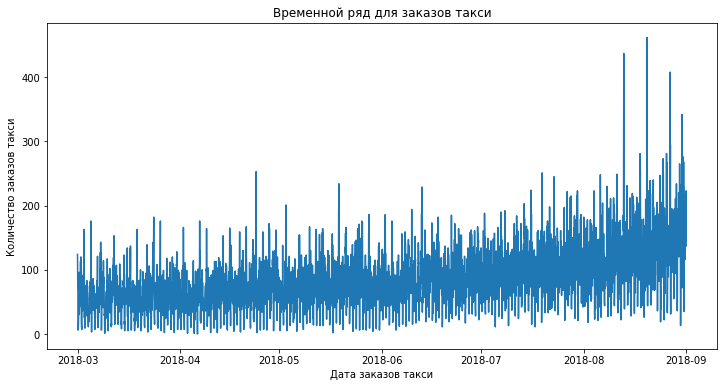

In [96]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.xlabel("Дата заказов такси")
plt.ylabel("Количество заказов такси")

plt.title("Временной ряд для заказов такси")
plt.plot(data)
plt.show()

График временного ряда количества заказов такси 

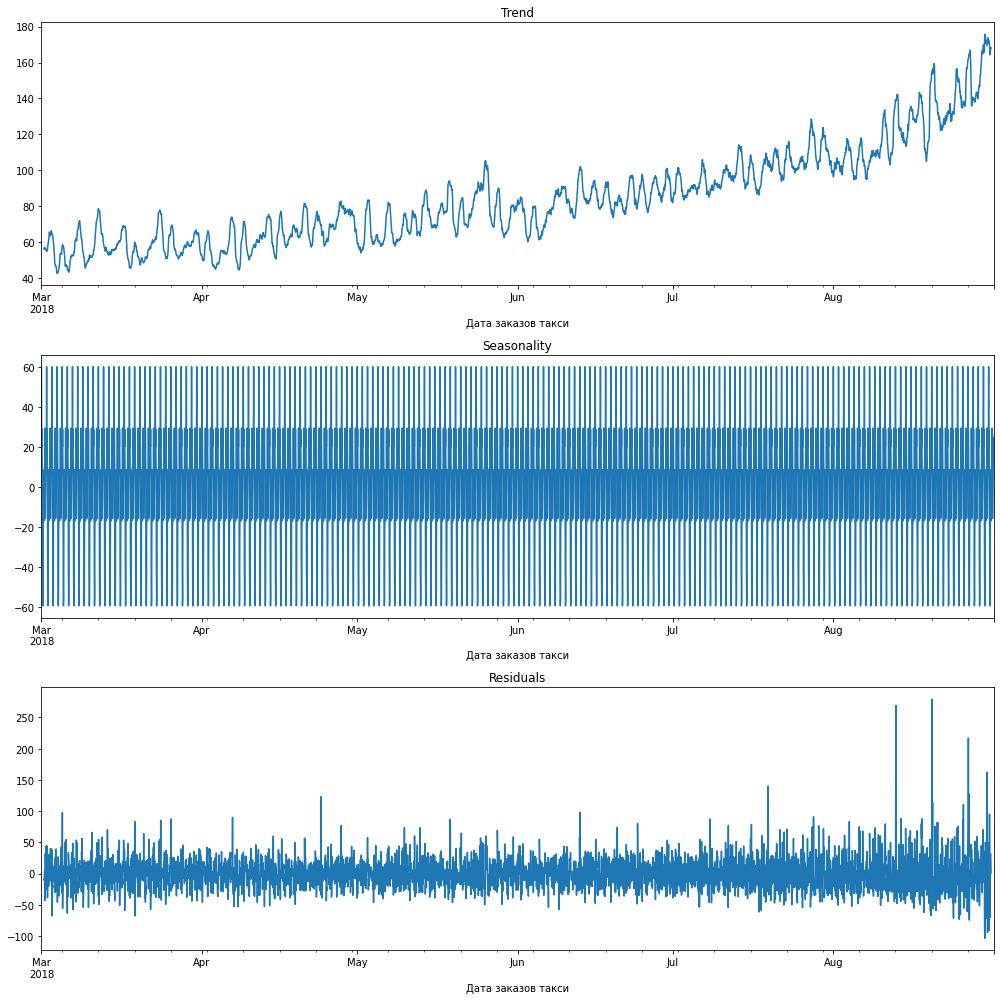

In [97]:
decomposed = seasonal_decompose(data) 

plt.rcParams['figure.figsize'] = [14, 14]
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.xlabel("Дата заказов такси")
plt.ylabel("Количество заказов такси")
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel("Дата заказов такси")
plt.ylabel("Количество заказов такси")
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.xlabel("Дата заказов такси")
plt.ylabel("Количество заказов такси")
plt.title('Residuals')
plt.tight_layout()

plt.show()

По графику тренда можно сказать, что есть увеличение количества заказов в течении года.

1. Вероятно, что суточная сезонность
2. Пики: 00:00, 15:00-16:00
3. Повышенный спрос на такси по выходным дням

График за 3 дня в пиковом месяце - августе

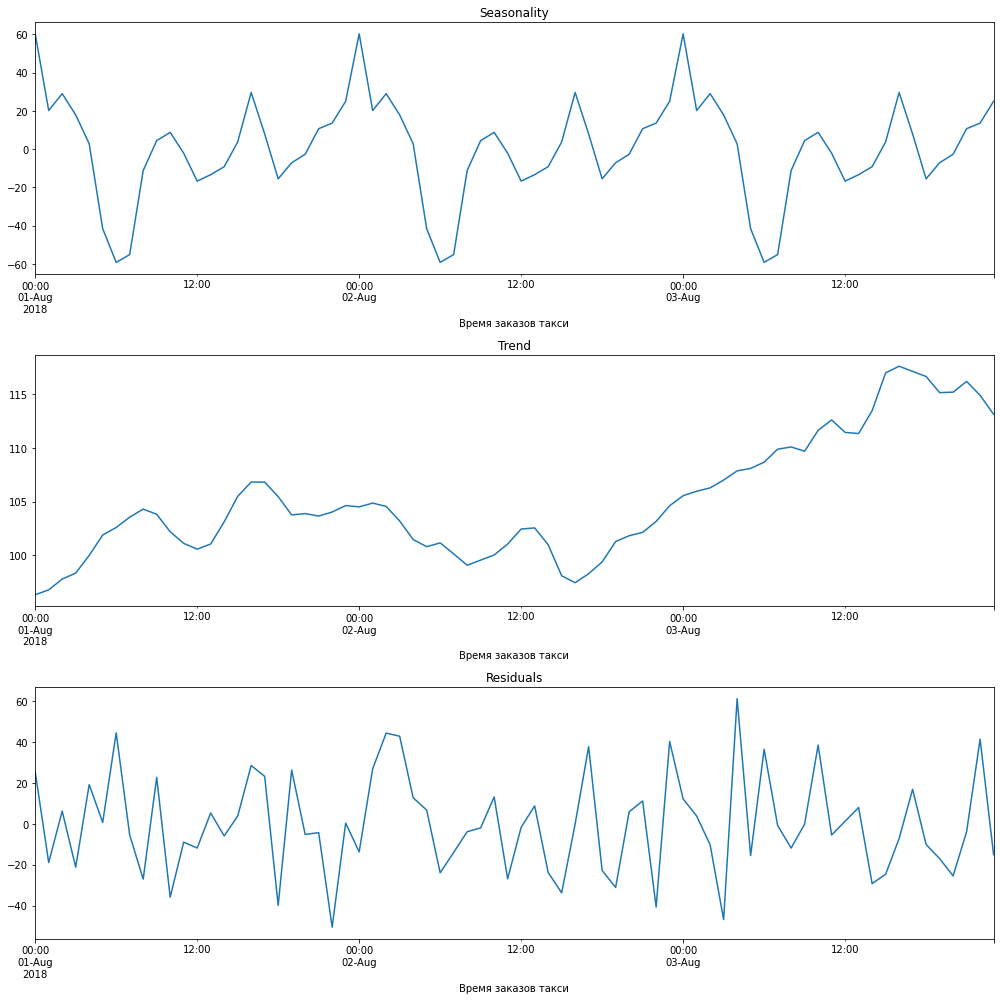

In [98]:
plt.rcParams['figure.figsize'] = [14, 14]
plt.subplot(311)

decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca())
plt.xlabel("Время заказов такси")
plt.ylabel("Количество заказов такси")
plt.title('Seasonality')

plt.subplot(312)
decomposed.trend['2018-08-01':'2018-08-03'].plot(ax=plt.gca())
plt.xlabel("Время заказов такси")
plt.ylabel("Количество заказов такси")
plt.title('Trend')
                 
plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-03'].plot(ax=plt.gca())
plt.xlabel("Время заказов такси")
plt.ylabel("Количество заказов такси")
plt.title('Residuals')
                 
plt.tight_layout()

Пик по заказам в 00:00, а меньше всего в районе 5-7 утра

In [99]:
data['mean'] = data['num_orders'].rolling(15, closed = 'left').mean()
data['std'] = data['num_orders'].rolling(15, closed = 'left').std()

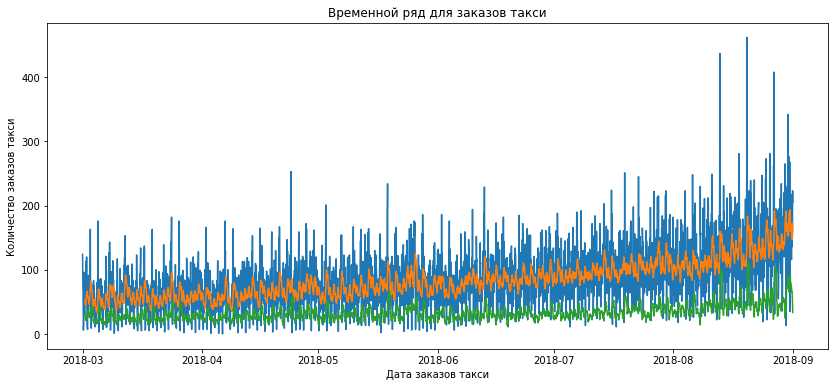

In [100]:
plt.rcParams['figure.figsize'] = [14, 6]
plt.xlabel("Дата заказов такси")
plt.ylabel("Количество заказов такси")
plt.title("Временной ряд для заказов такси")
plt.plot(data)
plt.show()

По исходному ряду можно сказать, что он нестационарен. Cреднее здесь меняется, что указывает на нестационарность ряда.

*Создадие признаков*

In [101]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [102]:
data = make_features(data, 30, 50)

*Промежуточный вывод:*

Убрал пропуски и провел описательную статистику

Вывыел графики тренда, сезона и остатков

Создал признаки для года, месяца, дня и дня недели 

## Обучение

Разделение данных в соотношении 9:1 (10% тестовой выборки)

In [103]:
train, test = train_test_split(data, test_size=0.1, shuffle=False)

In [104]:
train = train.dropna()

In [105]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Линейная регрессия

In [106]:
time_split = TimeSeriesSplit(n_splits=5)

model = LinearRegression()
CV = cross_val_score(model, features_train, target_train, cv=time_split, scoring='neg_mean_squared_error')

In [107]:
rmse = round((-CV.mean()) ** 0.5, 2)
f"RMSE: {rmse}"

'RMSE: 26.91'

In [108]:
model_decision_tree = DecisionTreeRegressor(random_state=42)

param_grid = {
    'min_samples_leaf': range(18, 28),
    'min_samples_split': range(2, 12),
    'max_depth': range(2, 6)
}

In [109]:
gs = GridSearchCV(model_decision_tree, 
             param_grid = param_grid, 
             scoring='neg_root_mean_squared_error', 
             cv=5,
            )

dt_model = gs.fit(features_train, target_train)

In [110]:
print(f'RMSE: {dt_model.best_score_ *-1}, параметры: {dt_model.best_params_}')

RMSE: 28.39385957827859, параметры: {'max_depth': 5, 'min_samples_leaf': 24, 'min_samples_split': 2}


In [111]:
model_lgbm_regressor = LGBMRegressor(random_state=42)

param_grid = {"n_estimators" : range(40, 50)}

gs = GridSearchCV(model_lgbm_regressor, 
                  param_grid = param_grid, 
                  scoring='neg_root_mean_squared_error', 
                  cv=5)

lgbm_model = gs.fit(features_train,target_train)

In [112]:
print(f'RMSE: {lgbm_model.best_score_ *-1}, параметры: {lgbm_model.best_params_}')

RMSE: 24.22062109547295, параметры: {'n_estimators': 49}


## Тестирование

Критерий: Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [113]:
#model_test = model.fit(features_train, target_train)
#predictions = model_test.predict(features_test)

#rmse_linear_test = mean_squared_error(target_test, predictions) ** 0.5

In [114]:
#rmse_linear_test

In [115]:
#tree_model_test = dt_model.fit(features_train,target_train)
#tree_predictions = dt_model_test.predict(features_test)

#rmse_tree_test = mean_squared_error(target_test, tree_predictions) ** 0.5

In [116]:
#rmse_tree_test

In [117]:
lgbm_model_test = lgbm_model.fit(features_train, target_train)
lgbm_predictions = lgbm_model_test.predict(features_test)

rmse_lgbm_test = mean_squared_error(target_test, lgbm_predictions) ** 0.5

In [118]:
rmse_lgbm_test

42.148389021513815

Вывод:
- RMSE LGBM на тестовой выборке - 42.1

**Проверка на адекватность** (результат тестирования нашей модели на тествой выборке лучше, чем результат константной модели):

In [119]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

mean_squared_error(target_test, pred_previous) ** 0.5

58.856486242815066

In [120]:
rmse_lgbm_test = mean_squared_error(target_test, lgbm_predictions) ** 0.5
rmse_lgbm_test

42.148389021513815

Общий вывод:
- Были исследованы данные по заказам такси в период с марта (03) по август (08) 2018 года. Выполнена проверка на пропуски и ресемплирование по часу.
- Выполнен анализ графиков временного ряда: тренд, сезонность и остатки
- Выполнено раздение на выборки в соотношении 9:1 (10% тестовой выборки) и обучены модели: линейной регрессии, дерева решений и LightGBM
- Посчитана метрика RMSE для каждой модели
- Результаты на тестовых данных:

RMSE линейной регрессии на тестовой выборке - 45.9

RMSE дерева решений на тестовой выборке - 54.2 (больше 48)

RMSE LGBM на тестовой выборке - 42.1
 - Самая лучшая модель - LightGBM с метрикой RMSE равной 42.1